# Projet 7 : Détecter les bads buzz grâce au Deep Learning - Air Paradis

- Problématique : Air Paradis a besoin de détecter les mauvais tweet afin de pouvoir agir rapidement.

Il faut ainsi développer un produit IA en utilisant 3 approches : 
- approche “API sur étagère” en utilisant l’API du service cognitif proposé par Microsoft Azure pour l’analyse de sentiment sur un échantillon des données
- approche “Modèle sur mesure simple” en utilisant le Concepteur / Designer d’un service Azure Machine Learning, interface graphique drag & drop, pour développer rapidement un modèle classique (ex : régression logistique) permettant de prédire le sentiment associé à un tweet.
- approche “Modèle sur mesure avancé” en utilisant le service Azure Machine Learning pour développer un modèle basé sur des réseaux de neurones profonds pour prédire le sentiment associé à un tweet qui sera présenté à Air Paradis

Les données utilisées sont des données opensource provenant de ce lien : https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+7%C2%A0-+D%C3%A9tectez+les+Bad+Buzz+gr%C3%A2ce+au+Deep+Learning/sentiment140.zip

Import des bibliothèques

In [275]:
import random
import os
# notre package de fonctionnalités
from Package import Scripts_Analyse01 as pk
from Package import Scripts_AnalyseMulti01 as pk_multi
from Package import Scripts_AnalyseMulti02_Unsupervised as pk_multi_unsp
from Package import Scripts_AnalyseMulti02_Supervised as pk_multi_sup
from IPython.core.display import display, HTML
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import pandas as pd
import numpy as np
import missingno
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from umap import UMAP
from scipy.stats import pearsonr
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from yellowbrick.features import ParallelCoordinates
from plotly.graph_objects import Layout
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.features import PCA as PCA_yellow
from yellowbrick.style import set_palette
from sklearn import metrics
from gensim.models.ldamodel import LdaModel
from  sklearn.feature_extraction.text  import CountVectorizer 
from sklearn.decomposition import SparsePCA
import gc
import time
from contextlib import contextmanager
from sklearn import cluster
import warnings
from dotenv import load_dotenv
import re
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from wordcloud import WordCloud
from unidecode import unidecode
from sklearn import metrics
from sklearn import manifold, decomposition
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from nltk.stem.snowball import SnowballStemmer
from spacy.language import Language
import spacy
from spacymoji import Emoji
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from hyperopt import fmin, tpe, hp, SparkTrials, STATUS_OK, Trials
from sklearn.metrics import make_scorer
from sklearn.svm import SVC
from functools import partial
from gensim.models import FastText  
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_val_score
warnings.simplefilter(action='ignore', category=FutureWarning)
%load_ext pycodestyle_magic


The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


In [273]:
from tqdm import tqdm,notebook
notebook.tqdm().pandas()

0it [00:00, ?it/s]

In [274]:
load_dotenv()

Python-dotenv could not parse statement starting at line 1


True

## Collecte des données

### Import des données

In [156]:
df = pd.read_csv('input/base.csv', encoding='latin-1', header=None)

In [157]:
df.shape

(1600000, 6)

In [158]:
df.head(2)

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


In [159]:
df = df.drop([3], axis=1)

In [160]:
df.head(2)

,0,1,2,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...


In [161]:
df.columns = ["target", "identity", "date", "username", "tweet"]

In [162]:
df.shape

(1600000, 5)

In [163]:
df.head(2)

,target,identity,date,username,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...


#### Nous conservons uniquement les classes positives et négatives 

In [164]:
part1 = df.loc[df["target"]==0]

In [165]:
part1 = part1.sample(800)

In [166]:
part2 = df.loc[df["target"]==4]

In [167]:
part2 = part2.sample(800)

In [168]:
df = pd.concat([part1, part2])

In [169]:
df.shape

(1600, 5)

### Export csv

In [170]:
df.to_csv("output/sample.csv")

In [171]:
df = pd.read_csv("output/sample.csv")

In [172]:
del df["Unnamed: 0"]

## Construction de la base de données

## Pré-traitement des données

Vérification des doublons

In [173]:
sum(df.duplicated())

0

In [174]:
df.head(2)

,target,identity,date,username,tweet
0,0,2063963976,Sun Jun 07 04:45:03 PDT 2009,Oh2BeTall,@drallenlubell do know anything about sphincte...
1,0,2018659971,Wed Jun 03 10:18:42 PDT 2009,kawtreenah,"its not lookin good Mr. Sun, its not lookin good"


Vérification des données manquantes

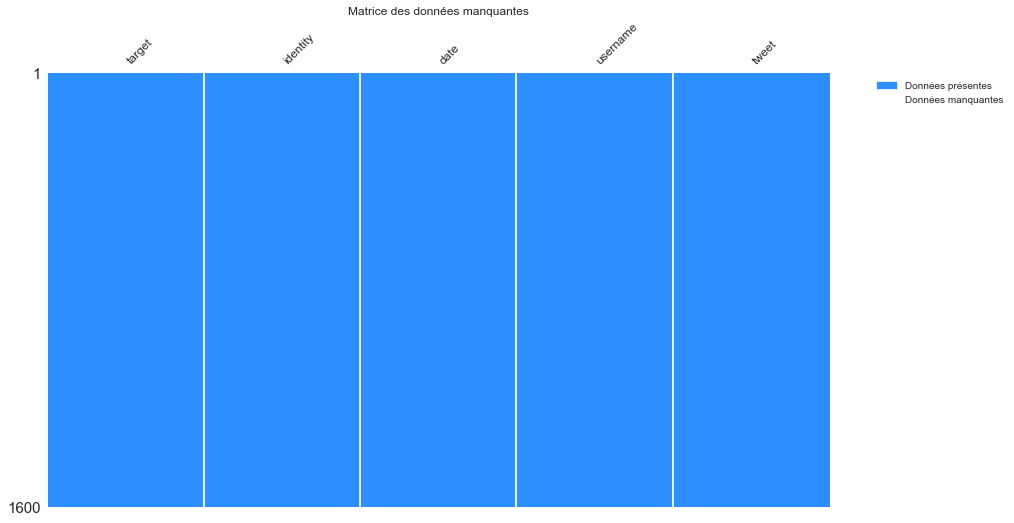

In [175]:
pk.matrix_vm(df, (14,8), (0.18, 0.56, 1))

Aucune donnée manquante

Passons au traitement du texte

In [176]:
df.head(2)

,target,identity,date,username,tweet
0,0,2063963976,Sun Jun 07 04:45:03 PDT 2009,Oh2BeTall,@drallenlubell do know anything about sphincte...
1,0,2018659971,Wed Jun 03 10:18:42 PDT 2009,kawtreenah,"its not lookin good Mr. Sun, its not lookin good"


Regardons le nombre de texte en fonction de la variable "TARGET"  qui représente la polarité du tweet (0 = negative, 2 = neutral et 4 = positive)

Avant créons une variable avec les libellées pour améliorer la lisibilité

In [177]:
def lib_polarite_target(target):
    if target == 0:
        return "Negative"
    elif target == 2:
        return "Neutral"
    elif target == 4:
        return "Positive"

df["target_lib"] = df["target"].progress_apply(lambda x: lib_polarite_target(x))

  0%|          | 0/1600 [00:00<?, ?it/s]

In [178]:
df.head(5)

,target,identity,date,username,tweet,target_lib
0,0,2063963976,Sun Jun 07 04:45:03 PDT 2009,Oh2BeTall,@drallenlubell do know anything about sphincte...,Negative
1,0,2018659971,Wed Jun 03 10:18:42 PDT 2009,kawtreenah,"its not lookin good Mr. Sun, its not lookin good",Negative
2,0,2064059763,Sun Jun 07 05:05:10 PDT 2009,ohglorymegan,Emily thought it'd be cool to just take my bla...,Negative
3,0,2217050969,Wed Jun 17 20:19:28 PDT 2009,brojoghost,@BlizzardSkies nothing will ever help Iran. We...,Negative
4,0,2265139701,Sun Jun 21 05:53:13 PDT 2009,itsamishmash,"drunk, and missing one of my best friends wedd...",Negative


Etudions notre variable

In [179]:
def graph_circle(data, column, title):
    """
    Graphique circulaire
    Args:
        data ([type]): données de la colonne à representer
        column ([type]): nom de la colonne
        title ([type]): titre du graphique
    Exemple:
    graph_circle(data["libelle_francais"], "libelle_francais",
                 "Répartition des arbres en fonction de leur appellation")
    """
    t = pd.crosstab(data, "freq", normalize=True)
    t = t.assign(column=t.index, freq=100 * t.freq)
    plt.figure(figsize=(18, 8))
    plt.pie(t.freq, labels=t.column,  autopct='%.0f%%')

    plt.title(title)
    my_circle = plt.Circle((0, 0), 0.4, color='white')
    p = plt.gcf()
    p.gca().add_artist(my_circle)

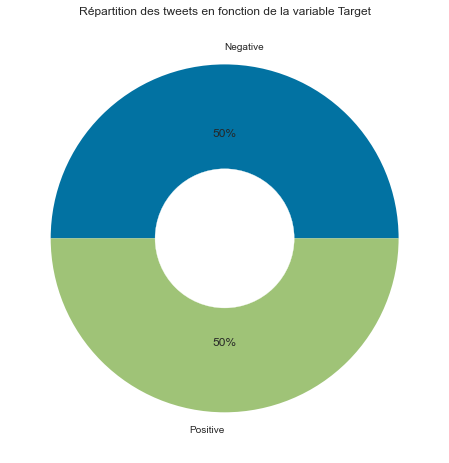

In [180]:
graph_circle(df["target_lib"], "Target",
                 "Répartition des tweets en fonction de la variable Target")

Nous observons que notre variable cible est à peu près équilibrée. En effet, nous retrouvons 57% de tweets avec un sentiment positif, contre 43% avec un sentiment negatif.

Traçons un wordcloud par classe même si le texte n'est pas encore nettoyé

In [181]:
gc.collect()

13697

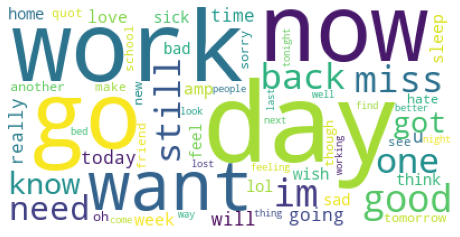

In [182]:
pk.wordcloud_plot(df.loc[df["target"]==0]["tweet"])

Nous avons ici des mots plutôt négatifs avec oh, never, horrible, burnt, byye, sorry, work, go.

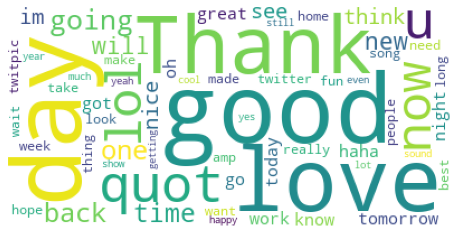

In [183]:
pk.wordcloud_plot(df.loc[df["target"]==4]["tweet"])

Nous retrouvons des mots positifs avec thank, good, well, yeah, love...

### Passons au nettoyage et à l'analyse de la variable "tweet"

In [184]:
df.head(2)

,target,identity,date,username,tweet,target_lib
0,0,2063963976,Sun Jun 07 04:45:03 PDT 2009,Oh2BeTall,@drallenlubell do know anything about sphincte...,Negative
1,0,2018659971,Wed Jun 03 10:18:42 PDT 2009,kawtreenah,"its not lookin good Mr. Sun, its not lookin good",Negative


In [185]:
df["tweet"][0]

"@drallenlubell do know anything about sphincter of oddi dysfunction? If so, can you pls send me a link? Dx'd but unable to do ERCP "

Nous observons que des tweets mélangent majuscule et minuscule. Nous allons donc mettre le texte en minuscule. Notons aussi que nous observons un @. Il faudra donc supprimer la ponctuation.

Pour cela, nous allons utiliser spacy. Et créer un pipeline que nous complèterons au fur et à mesure afin d'avoir un texte nettoyé.
Nous mettrons donc par la suite notre texte en minuscule et nous supprimerons la ponctuation.

Nous savons que dans les tweets, nous pouvons trouver : 
- des emoticônes et des emojicônes
- des mentions (ex : @toto)
- des hashtags (ex #toureiffel)
- des reponses directes à d'autres tweets, qui seront notées avec "RE"
- des emails
- des urls

En conséquence, nous devons retranscrire les emojicônes/emoticônes car ils expriments un sentiment. 
Et il nous faut supprimer les autres éléments qui n'apportent pas forcément d'informations sur le sentiment du tweet, excepté pour les hashtags qui peuvent exprimer des sentiments tel que #encolere

Commençons par ajouter au pipeline l'identification des emoticônes et des emojicônes en premier

Pour rappel, dans le pipeline de spacy nous avons !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [186]:
nlp = spacy.load("en_core_web_sm")
_ = nlp.add_pipe("emoji", first=True)

In [187]:
nlp.pipe_names

['emoji',
 'tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner']

In [188]:
gc.collect()

10916

Nous avons bien ajouté emoji en premier. Vérifions que cela fonctionne avec un texte

In [189]:
doc = nlp("Dr. Alex Smith :-) 😂 chaired LMAO first board meeting of Acme Corp Inc. titi@gmail.com <https://t.co> Re")
print([(token.text, token._.is_emoji) for token in doc])

[('Dr.', False), ('Alex', False), ('Smith', False), (':-)', False), ('😂', True), ('chaired', False), ('LMAO', False), ('first', False), ('board', False), ('meeting', False), ('of', False), ('Acme', False), ('Corp', False), ('Inc.', False), ('titi@gmail.com', False), ('<', False), ('https://t.co', False), ('>', False), ('Re', False)]


Notre emojicône est bien détectée contrairement à l'emoticône. Il nous faudra donc ajouter une autre méthode.
Vérifions si nous pouvons détecter les url, les e-mails et la ponctuation.

!!!!!!!!!!!!!!!!!!!! problem ROFL | LOL | LMAO + :) :(

In [190]:
print([(token.text,token.is_punct, token._.is_emoji, token._.emoji_desc, token.like_email, token.is_stop) for token in doc])

[('Dr.', False, False, None, False, False), ('Alex', False, False, None, False, False), ('Smith', False, False, None, False, False), (':-)', True, False, None, False, False), ('😂', False, True, 'face with tears of joy', False, False), ('chaired', False, False, None, False, False), ('LMAO', False, False, None, False, False), ('first', False, False, None, False, True), ('board', False, False, None, False, False), ('meeting', False, False, None, False, False), ('of', False, False, None, False, True), ('Acme', False, False, None, False, False), ('Corp', False, False, None, False, False), ('Inc.', False, False, None, False, False), ('titi@gmail.com', False, False, None, True, False), ('<', False, False, None, False, False), ('https://t.co', False, False, None, False, False), ('>', False, False, None, False, False), ('Re', False, False, None, False, True)]


Nous détectons bien ces informations.

Ajoutons "RE" dans les stopwords qui apparait lors de la réponse direct à un tweet

Voici un extrait de la liste des stopwords.

In [191]:
#Printing first ten stop words:
print('First ten stop words: ', print(nlp.Defaults.stop_words))

{'yourselves', 'alone', 'around', 'hereupon', 'amongst', 'everyone', '’ve', 'while', 'her', 'only', 'yourself', 'will', 'therein', 'whence', 'keep', 'just', 'become', 'were', 'be', 'n’t', 'twenty', 'towards', 'thereupon', 'these', 'some', 'back', 'show', 'behind', 'into', 'six', 'someone', "'ve", 'twelve', '’m', 'still', 'would', 'whom', 'which', 'call', 'this', 'ever', 'without', 'per', 'himself', 'anyone', 'eight', 'also', 'its', 'them', 'did', 'no', 'your', 'own', 'any', 'thereafter', 'was', 'they', 'whereupon', 'whole', 'yet', 'could', 'nobody', 'ours', 'almost', 'thence', 'where', 'on', 'before', 'front', 'if', 'such', 'get', 'wherever', 'beyond', 'unless', 'under', 'eleven', 'nor', 'since', "'re", 'various', 'becomes', 'anything', 'should', 'thus', 'otherwise', 'ourselves', 'and', 'my', 'other', 'about', 'might', 'by', 'very', 'herein', 'through', 'wherein', 'n‘t', 'thru', 'seems', '‘re', 'always', 'noone', 'it', 'most', 'itself', 'though', 'below', '‘d', 'amount', 'same', "n't",

Ajoutons "RE"

In [192]:
nlp.Defaults.stop_words.add("re")

In [193]:
print([(token.text,token.is_punct, token._.is_emoji, token._.emoji_desc, token.like_email, token.is_stop) for token in doc])

[('Dr.', False, False, None, False, False), ('Alex', False, False, None, False, False), ('Smith', False, False, None, False, False), (':-)', True, False, None, False, False), ('😂', False, True, 'face with tears of joy', False, False), ('chaired', False, False, None, False, False), ('LMAO', False, False, None, False, False), ('first', False, False, None, False, True), ('board', False, False, None, False, False), ('meeting', False, False, None, False, False), ('of', False, False, None, False, True), ('Acme', False, False, None, False, False), ('Corp', False, False, None, False, False), ('Inc.', False, False, None, False, False), ('titi@gmail.com', False, False, None, True, False), ('<', False, False, None, False, False), ('https://t.co', False, False, None, False, False), ('>', False, False, None, False, False), ('Re', False, False, None, False, True)]


"Re" est donc bien détecté comme un stopword.

Créons une fonction pour détecter les mentions dans les tweets (ex: @toto)

In [194]:
from spacy.tokens import Token

# Définit l'extension sur le Token avec une valeur par défaut
#Token.set_extension("is_mention", default=False)

def is_mention_function(token):
    if token.text.startswith("@") == True and len(token.text)>1:
        return True
        
Token.set_extension("is_mention", getter=is_mention_function, force=True)

In [195]:
doc = nlp("I have @toto")
for token in doc:
    if token._.is_mention == True:
        print(token._.is_mention)

True


La mention est bien détectée

Nous pouvons donc créer un nouveau composant qui permettra d'obtenir nos mots nettoyés

In [196]:
# Définit un composant personnalisé
def text_clean_function(doc):
    new_words = []
    for token in doc:
        if token._.is_emoji:
            if token._.emoji_desc != " ":
                new_words.append(token._.emoji_desc)
            else:
                continue
        elif token.like_email or token.is_stop or token.like_url:
            continue
        elif token._.is_mention == True:
            continue
        elif token.is_punct:
            continue
        else :
            if token.text.strip() != "":
                new_words.append(token.text)
    return new_words


In [197]:
from spacy.tokens import Doc

@Language.component("pre_process_text")
def pre_process_text_function(doc):
    # Generate a new list of tokens here
    new_words = text_clean_function(doc)
    new_doc = Doc(doc.vocab, words=new_words)
    return new_doc

In [198]:
# Ajoute le composant en premier dans le pipeline
nlp.add_pipe("pre_process_text", before="tok2vec")

<function __main__.pre_process_text_function(doc)>

In [199]:
nlp.pipe_names

['emoji',
 'pre_process_text',
 'tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner']

In [200]:
doc = nlp("Dr. Alex Smith :-) 😂 @toto chaired LMAO first board meeting of Acme Corp Inc. titi@gmail.com <https://t.co> Re")


In [201]:
def stemming_function(doc):
    stemmer = SnowballStemmer(language='english')
    list_doc = []
    for token in doc:
        print(token.text)
        list_doc.append(stemmer.stem(token.text))
    return list_doc

In [202]:
test = stemming_function(doc)

Dr.
Alex
Smith
face with tears of joy
chaired
LMAO
board
meeting
Acme
Corp
Inc.
<
>


In [203]:
doc.text

'Dr. Alex Smith face with tears of joy chaired LMAO board meeting Acme Corp Inc. < > '

In [204]:
test

['dr.',
 'alex',
 'smith',
 'face with tears of joy',
 'chair',
 'lmao',
 'board',
 'meet',
 'acm',
 'corp',
 'inc.',
 '<',
 '>']

In [205]:
from spacy.tokens import Token

# Définit l'extension sur le Token avec une valeur par défaut
#Token.set_extension("is_mention", default=False)
def stemming_function(token):
    stemmer = SnowballStemmer(language='english')
    stem = stemmer.stem(token.text)
    return stem

Token.set_extension("stemming_", getter=stemming_function, force=True)

In [206]:
doc = nlp("Dr. Alex Smith :-) 😂 @toto chaired LMAO first board meeting of Acme Corp Inc. titi@gmail.com <https://t.co> Re")


In [207]:
for token in doc:
    print(token._.stemming_)

dr.
alex
smith
face with tears of joy
chair
lmao
board
meet
acm
corp
inc.
<
>


In [208]:
df["tweet_clean"] = df["tweet"].progress_apply(lambda x: nlp(x))

  0%|          | 0/1600 [00:00<?, ?it/s]

In [209]:
df["tweet_lemma"] = df["tweet"].progress_apply(lambda x: [token.lemma_ for token in nlp(x)])

  0%|          | 0/1600 [00:00<?, ?it/s]

In [210]:
df["tweet_stem"] = df["tweet"].progress_apply(lambda x: [token._.stemming_ for token in nlp(x)])

  0%|          | 0/1600 [00:00<?, ?it/s]

In [211]:
df.head(2)

,target,identity,date,username,tweet,target_lib,tweet_clean,tweet_lemma,tweet_stem
0,0,2063963976,Sun Jun 07 04:45:03 PDT 2009,Oh2BeTall,@drallenlubell do know anything about sphincte...,Negative,"(know, sphincter, oddi, dysfunction, pls, send...","[know, sphincter, oddi, dysfunction, pls, send...","[know, sphincter, oddi, dysfunct, pls, send, l..."
1,0,2018659971,Wed Jun 03 10:18:42 PDT 2009,kawtreenah,"its not lookin good Mr. Sun, its not lookin good",Negative,"(lookin, good, Mr., Sun, lookin, good)","[lookin, good, Mr., Sun, lookin, good]","[lookin, good, mr., sun, lookin, good]"


Nous ne supprimons pas les # car on peut avoir des #encolere

In [212]:
import spacy
from spacy.matcher import Matcher

nlp = spacy.load("en_core_web_sm")
matcher = Matcher(nlp.vocab)


pattern =  [{'ORTH': '#'}, {'IS_ASCII': True}]
matcher.add('HASHTAG', [pattern])

doc = nlp("Hello, world! Hello world! ###toto")
matches = matcher(doc)
for match_id, start, end in matches:
    string_id = nlp.vocab.strings[match_id]  # Get string representation
    span = doc[start:end]  # The matched span
    print( string_id, start, end, span.text)

    

HASHTAG 7 9 ##
HASHTAG 8 10 ##
HASHTAG 9 11 #toto


In [213]:
df.head(3)

,target,identity,date,username,tweet,target_lib,tweet_clean,tweet_lemma,tweet_stem
0,0,2063963976,Sun Jun 07 04:45:03 PDT 2009,Oh2BeTall,@drallenlubell do know anything about sphincte...,Negative,"(know, sphincter, oddi, dysfunction, pls, send...","[know, sphincter, oddi, dysfunction, pls, send...","[know, sphincter, oddi, dysfunct, pls, send, l..."
1,0,2018659971,Wed Jun 03 10:18:42 PDT 2009,kawtreenah,"its not lookin good Mr. Sun, its not lookin good",Negative,"(lookin, good, Mr., Sun, lookin, good)","[lookin, good, Mr., Sun, lookin, good]","[lookin, good, mr., sun, lookin, good]"
2,0,2064059763,Sun Jun 07 05:05:10 PDT 2009,ohglorymegan,Emily thought it'd be cool to just take my bla...,Negative,"(Emily, thought, cool, blanket, pillow, come, ...","[Emily, think, cool, blanket, pillow, come, help]","[emili, thought, cool, blanket, pillow, come, ..."


In [214]:
gc.collect()

8604

#### !!!!!!!!!!!!retraçons les wordcloud par classe et par methode stem / lemma

In [215]:
df["tweet_lemma_join"] = df["tweet_lemma"].progress_apply(lambda x: " ".join(x))

  0%|          | 0/1600 [00:00<?, ?it/s]

In [216]:
df["tweet_stem_join"] = df["tweet_stem"].progress_apply(lambda x: " ".join(x))

  0%|          | 0/1600 [00:00<?, ?it/s]

In [217]:
df.head(2)

,target,identity,date,username,tweet,target_lib,tweet_clean,tweet_lemma,tweet_stem,tweet_lemma_join,tweet_stem_join
0,0,2063963976,Sun Jun 07 04:45:03 PDT 2009,Oh2BeTall,@drallenlubell do know anything about sphincte...,Negative,"(know, sphincter, oddi, dysfunction, pls, send...","[know, sphincter, oddi, dysfunction, pls, send...","[know, sphincter, oddi, dysfunct, pls, send, l...",know sphincter oddi dysfunction pls send link ...,know sphincter oddi dysfunct pls send link dx'...
1,0,2018659971,Wed Jun 03 10:18:42 PDT 2009,kawtreenah,"its not lookin good Mr. Sun, its not lookin good",Negative,"(lookin, good, Mr., Sun, lookin, good)","[lookin, good, Mr., Sun, lookin, good]","[lookin, good, mr., sun, lookin, good]",lookin good Mr. Sun lookin good,lookin good mr. sun lookin good


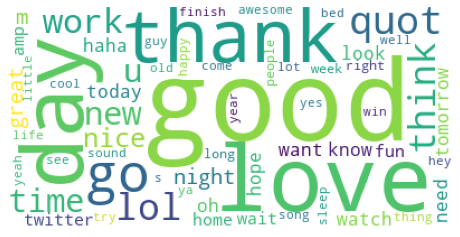

In [218]:
pk.wordcloud_plot(df.loc[df["target"]==4]["tweet_lemma_join"])

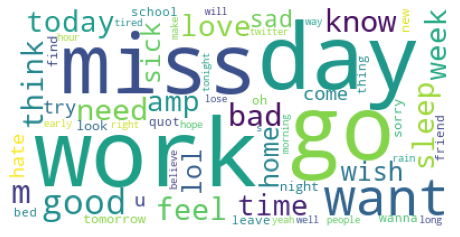

In [219]:
pk.wordcloud_plot(df.loc[df["target"]==0]["tweet_lemma_join"])

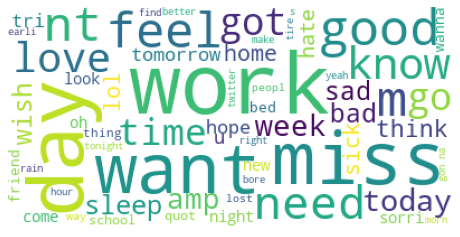

In [220]:
pk.wordcloud_plot(df.loc[df["target"]==0]["tweet_stem_join"])

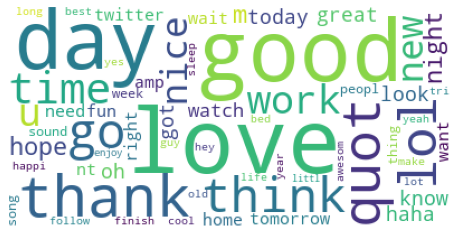

In [221]:
pk.wordcloud_plot(df.loc[df["target"]==4]["tweet_stem_join"])

Nous conservons donc la méthode de lemmatisation. Nous pouvons supprimer les colonnes contenant les données de stemming.

In [ ]:
df.drop(["tweet_stem", "tweet_stem_join"], axis=1)

La technique de lemmatization supprime surement des commentaires qui n'ont pas de sens tel que "I will go".
Nous supprimons donc les lignes vides.

In [222]:
df = df.loc[df["tweet_lemma"] != np.array(0)]

In [223]:
df.shape

(1584, 11)

In [ ]:
graph_circle(df["target_lib"], "Target",
                 "Répartition des tweets en fonction de la variable Target")

## Feature engineering

Deux méthodes : Glove, Fasttext

### Commençons par Glove

- Algorithme pour l'incorporation de mots :
- Prétraitez les données textuelles.
- Créé le dictionnaire.
- Parcourir le fichier glove d'une dimension précise et comparer chaque mot avec tous les mots du dictionnaire,
- si une correspondance se produit, copiez le vecteur équivalent du gant et collez-le dans embedding_matrix à l'index correspondant.

In [224]:
df.head(2)

,target,identity,date,username,tweet,target_lib,tweet_clean,tweet_lemma,tweet_stem,tweet_lemma_join,tweet_stem_join
0,0,2063963976,Sun Jun 07 04:45:03 PDT 2009,Oh2BeTall,@drallenlubell do know anything about sphincte...,Negative,"(know, sphincter, oddi, dysfunction, pls, send...","[know, sphincter, oddi, dysfunction, pls, send...","[know, sphincter, oddi, dysfunct, pls, send, l...",know sphincter oddi dysfunction pls send link ...,know sphincter oddi dysfunct pls send link dx'...
1,0,2018659971,Wed Jun 03 10:18:42 PDT 2009,kawtreenah,"its not lookin good Mr. Sun, its not lookin good",Negative,"(lookin, good, Mr., Sun, lookin, good)","[lookin, good, Mr., Sun, lookin, good]","[lookin, good, mr., sun, lookin, good]",lookin good Mr. Sun lookin good,lookin good mr. sun lookin good


In [225]:
df["tweet_lemma"][0]

['know',
 'sphincter',
 'oddi',
 'dysfunction',
 'pls',
 'send',
 'link',
 "Dx'd",
 'unable',
 'ERCP']

In [226]:
# Change the current working directory
os.chdir(r'D:Users\Aurel\OneDrive_N\OneDrive\_WORK0\IngenieurIA\projets\Projet7BadBuzz\OP_Project7')

# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))

FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: 'D:Users\\Aurel\\OneDrive_N\\OneDrive\\_WORK0\\IngenieurIA\\projets\\Projet7BadBuzz\\OP_Project7'

In [227]:
emmbed_dict = {}
with open('Input/glove.6B/glove.6B.200d.txt','r') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:],'float32')
    emmbed_dict[word]=vector

In [228]:
# code for Glove word embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
  
x = df["tweet_lemma"]
  
# create the dict.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x)

In [229]:
# number of unique words in dict.
print("Number of unique words in dictionary=", 
      len(tokenizer.word_index))
print("Dictionary is = ", tokenizer.word_index)
  
# download glove and unzip it in Notebook.
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove*.zip
  
# vocab: 'the': 1, mapping of words with
# integers in seq. 1,2,3..
# embedding: 1->dense vector
def embedding_for_vocab(filepath, word_index,
                        embedding_dim):
    vocab_size = len(word_index) + 1
      
    # Adding again 1 because of reserved 0 index
    embedding_matrix_vocab = np.zeros((vocab_size,
                                       embedding_dim))
  
    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix_vocab[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
  
    return embedding_matrix_vocab
  
  
# matrix for vocab: word_index
embedding_dim = 50
path = r'input/glove.6B/glove.6B.50d.txt'
embedding_matrix_vocab = embedding_for_vocab(
    path, tokenizer.word_index,
  embedding_dim)
  
print("Dense vector for first word is => ",
      embedding_matrix_vocab[1])

Number of unique words in dictionary= 3664
Dictionary is =  {'good': 1, 'day': 2, 'go': 3, 'like': 4, 'work': 5, 'love': 6, 'get': 7, 'want': 8, 'think': 9, 'm': 10, 'lol': 11, 'not': 12, 'know': 13, 'time': 14, 'today': 15, 'miss': 16, 'need': 17, 'thank': 18, 'u': 19, 'night': 20, 'look': 21, 'new': 22, 'feel': 23, 'week': 24, 'sleep': 25, 'tomorrow': 26, 'oh': 27, 'home': 28, 'bad': 29, 'come': 30, 'hope': 31, 'amp': 32, 'try': 33, 'nice': 34, '2': 35, 'haha': 36, 'watch': 37, 'thing': 38, 'great': 39, 'to': 40, 'twitter': 41, 'people': 42, 'wish': 43, 'morning': 44, 'wait': 45, 'bed': 46, 'right': 47, 'sad': 48, 'happy': 49, '3': 50, 'friend': 51, 'hate': 52, 'long': 53, 'find': 54, 'well': 55, 'yeah': 56, 'sick': 57, 'way': 58, 'see': 59, 'tonight': 60, 'leave': 61, 'wanna': 62, 'cool': 63, 'sound': 64, 'make': 65, 'year': 66, 'sorry': 67, 'school': 68, '4': 69, 'fun': 70, 'life': 71, 'yes': 72, 'early': 73, 'little': 74, 'win': 75, 's': 76, 'old': 77, 'start': 78, 'hour': 79, 'lo

In [230]:
embedding_matrix_vocab

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.35585999,  0.52130002, -0.61070001, ...,  0.27206999,
         0.31305   ,  0.92771   ],
       [ 0.11626   ,  0.53896999, -0.39513999, ..., -0.39061999,
        -0.10885   ,  0.084513  ],
       ...,
       [-0.94415998, -0.30311999, -0.20235001, ..., -1.05350006,
         0.58445001,  0.71354002],
       [ 0.45144999,  0.31307   , -1.5711    , ..., -0.39265999,
        -0.28088   ,  0.059961  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [231]:
embedding_matrix_vocab

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.35585999,  0.52130002, -0.61070001, ...,  0.27206999,
         0.31305   ,  0.92771   ],
       [ 0.11626   ,  0.53896999, -0.39513999, ..., -0.39061999,
        -0.10885   ,  0.084513  ],
       ...,
       [-0.94415998, -0.30311999, -0.20235001, ..., -1.05350006,
         0.58445001,  0.71354002],
       [ 0.45144999,  0.31307   , -1.5711    , ..., -0.39265999,
        -0.28088   ,  0.059961  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [232]:
import spacy
nlp = spacy.load('en_vectors_web_lg')

total_vectors = len(nlp.vocab.vectors)
print('Total word vectors:', total_vectors)

unique_words = list(set([word for sublist in tokenized_corpus for word in sublist]))

word_glove_vectors = np.array([nlp(word).vector for word in unique_words])
vec_df = pd.DataFrame(word_glove_vectors, index=unique_words)
vec_df

OSError: [E050] Can't find model 'en_vectors_web_lg'. It doesn't seem to be a Python package or a valid path to a data directory.

## Réduction de dimensions

## ACP

In [173]:
Z = pk_multi.amulti_acp_standard(embedding_matrix_vocab)


50
[4.45160061e+00 3.86178884e+00 2.91277283e+00 2.56333911e+00
 2.43494811e+00 2.03818109e+00 1.94392929e+00 1.83778817e+00
 1.56360552e+00 1.48943834e+00 1.44526154e+00 1.40774210e+00
 1.35772657e+00 1.26029915e+00 1.21039009e+00 1.12577007e+00
 1.10517150e+00 1.06263587e+00 1.01758683e+00 9.62024210e-01
 9.25536933e-01 8.54615612e-01 8.19186050e-01 7.97330101e-01
 7.63807713e-01 7.46661624e-01 7.38040032e-01 6.86776466e-01
 6.57845926e-01 6.04576555e-01 5.67461950e-01 5.49479745e-01
 5.22694556e-01 5.01788939e-01 4.53315838e-01 4.34572525e-01
 4.20659452e-01 4.00991575e-01 3.69475252e-01 3.36234021e-01
 3.18692604e-01 2.80287225e-01 2.53267214e-01 1.55796075e-02
 1.39869597e-02 1.06934852e-02 7.30502000e-03 5.58865481e-03
 4.68034860e-03 3.69062539e-03]
[8.88244783e-02 7.70557400e-02 5.81196629e-02 5.11472792e-02
 4.85854449e-02 4.06686018e-02 3.87879598e-02 3.66700856e-02
 3.11992149e-02 2.97193291e-02 2.88378527e-02 2.80892129e-02
 2.70912341e-02 2.51472278e-02 2.41513734e-02 2.24

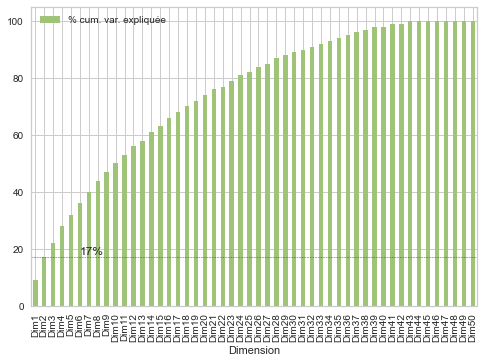

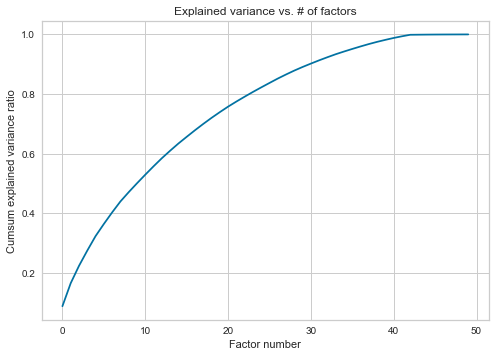

In [174]:
pk_multi.amulti_acp_choice_dim(embedding_matrix_vocab, Z)

In [176]:
transformer = SparsePCA(n_components=12, random_state=0)
transformer.fit(embedding_matrix_vocab)

X_transformed = transformer.transform(embedding_matrix_vocab)
X_transformed.shape

# most values in the components_ are zero (sparsity)
np.mean(transformer.components_ == 0)

0.7083333333333334

[Text(0.5, 1.0, 'Data SparsePCA projection')]

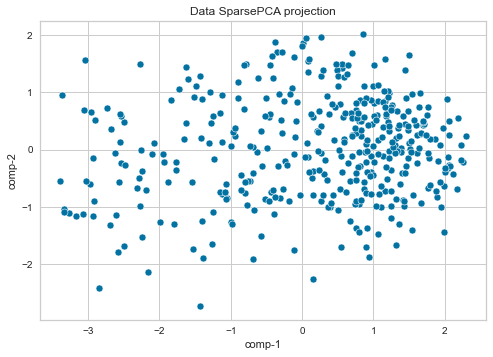

In [177]:
df_sparseacp = pd.DataFrame()
df_sparseacp["comp-1"] = X_transformed[:,0]
df_sparseacp["comp-2"] = X_transformed[:,1]

sns.scatterplot(x="comp-1", y="comp-2", #hue=df_sparseacp.y.tolist(),
                #palette=sns.color_palette("hls", 3),
                data=df_sparseacp).set(title="Data SparsePCA projection") 

In [178]:
Z = pk_multi.amulti_acp_standard(X_transformed)

12
[1.92025354 1.73281211 1.40938184 1.16880765 1.0207384  0.96790029
 0.85078514 0.70135908 0.65935641 0.61405341 0.55319781 0.42939171]
[0.15964812 0.14406441 0.11717471 0.0971736  0.08486325 0.08047034
 0.0707335  0.05831035 0.05481829 0.05105184 0.04599236 0.03569923]
   Dimension  Valeurs propres  % variance expliquée  % cum. var. expliquée
0       Dim1         1.915777                  16.0                   16.0
1       Dim2         1.728773                  14.0                   30.0
2       Dim3         1.406097                  12.0                   42.0
3       Dim4         1.166083                  10.0                   52.0
4       Dim5         1.018359                   8.0                   60.0
5       Dim6         0.965644                   8.0                   68.0
6       Dim7         0.848802                   7.0                   75.0
7       Dim8         0.699724                   6.0                   81.0
8       Dim9         0.657819                   5.0 

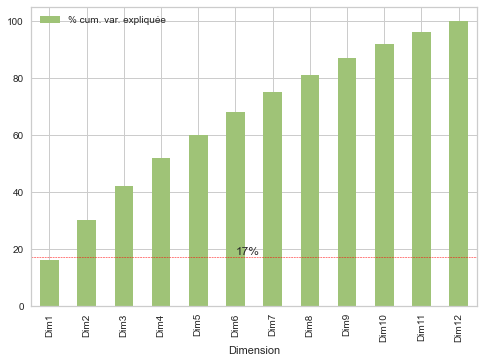

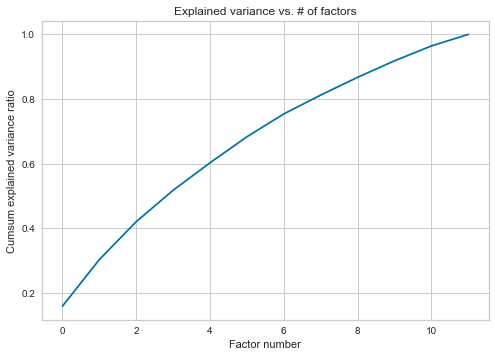

In [179]:
pk_multi.amulti_acp_choice_dim(X_transformed, Z)

## T-SNE

In [184]:
embedding_matrix_vocab

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.14827999,  0.17761   ,  0.42346001, ..., -0.2182    ,
         0.12971   ,  0.32953   ],
       [-0.0044021 , -0.34141001, -0.22729   , ..., -0.25263   ,
        -0.29477   ,  0.611     ],
       ...,
       [-0.60794997,  1.23150003,  0.79654002, ..., -0.35234001,
         0.39078999,  0.1189    ],
       [-0.049027  ,  0.29817   , -0.35953999, ..., -0.23423   ,
         0.65412003,  0.19246   ],
       [-0.50445998, -0.024438  ,  0.92768002, ...,  0.28751999,
         0.68601   , -0.17896   ]])

### Passons à Fasttext

In [234]:
df["tweet_lemma"][0]

['know',
 'sphincter',
 'oddi',
 'dysfunction',
 'pls',
 'send',
 'link',
 "Dx'd",
 'unable',
 'ERCP']

In [237]:
# Defining values for parameters
embedding_size = 300
window_size = 5
min_word = 5
#down_sampling = 1e-2
 
fast_Text_model = FastText(df["tweet_lemma"],
                      window=window_size,
                      min_count=min_word,
                      #sample=down_sampling,
                      workers = 4,
                      sg=1)

In [238]:
fast_Text_model.wv["happy"]

array([-3.33023183e-02,  6.33239597e-02, -9.07067806e-02,  3.30830030e-02,
       -1.24760598e-01, -1.00191049e-01,  3.67681012e-02,  1.15906797e-01,
       -3.76115255e-02, -5.38650341e-02,  3.73960808e-02, -1.08264960e-01,
       -1.01745557e-02,  1.87042311e-01,  1.64011568e-01,  5.15860855e-04,
        1.64632462e-02, -4.66103926e-02, -7.18537122e-02, -2.34034315e-01,
       -2.13403419e-01, -1.54782680e-03, -6.94217384e-02, -9.77654085e-02,
       -1.00386113e-01, -6.13764115e-03, -2.71146335e-02, -6.55594319e-02,
        1.11730531e-01, -8.27788841e-03,  7.61053199e-03, -1.01158865e-01,
        1.46456733e-01,  8.99303798e-03, -6.37281165e-02,  1.17815949e-01,
       -2.32516378e-01,  2.88553406e-02, -1.08584166e-01, -1.60702448e-02,
       -4.72039096e-02, -1.25913650e-01, -8.10174923e-03, -1.57607362e-01,
       -1.02648810e-01, -3.21753845e-02, -1.85163334e-01,  5.89754768e-02,
       -1.26632661e-01,  1.76671408e-02,  8.55255872e-02,  5.87211661e-02,
        9.31688100e-02,  

In [239]:
fast_Text_model.wv.most_similar(positive="best")

[('yesterday', 0.9988861680030823),
 ('today', 0.9988822340965271),
 ('home', 0.9988815784454346),
 ('amazing', 0.998867392539978),
 ('way', 0.9988619089126587),
 ('birthday', 0.9988479614257812),
 ('tonight', 0.9988471269607544),
 ('make', 0.9988466501235962),
 ('time', 0.9988448619842529),
 ('fight', 0.9988438487052917)]

In [240]:
df.shape

(1584, 11)

on va donc tokeniser le corpus et pour le mot go du premier document on va calculer les similarités avec les autres mots

In [241]:
def get_vect(word, model):
    try:
        return model.wv[word]
    except KeyError:
        return np.zeros((model.vector_size,))

def sum_vectors(phrase, model):
    return sum(get_vect(w, model) for w in phrase)


In [242]:
df.head(2)

,target,identity,date,username,tweet,target_lib,tweet_clean,tweet_lemma,tweet_stem,tweet_lemma_join,tweet_stem_join
0,0,2063963976,Sun Jun 07 04:45:03 PDT 2009,Oh2BeTall,@drallenlubell do know anything about sphincte...,Negative,"(know, sphincter, oddi, dysfunction, pls, send...","[know, sphincter, oddi, dysfunction, pls, send...","[know, sphincter, oddi, dysfunct, pls, send, l...",know sphincter oddi dysfunction pls send link ...,know sphincter oddi dysfunct pls send link dx'...
1,0,2018659971,Wed Jun 03 10:18:42 PDT 2009,kawtreenah,"its not lookin good Mr. Sun, its not lookin good",Negative,"(lookin, good, Mr., Sun, lookin, good)","[lookin, good, Mr., Sun, lookin, good]","[lookin, good, mr., sun, lookin, good]",lookin good Mr. Sun lookin good,lookin good mr. sun lookin good


In [243]:

df["vector"] = df["tweet_lemma"].progress_apply(lambda x: [ sum_vectors(y, fast_Text_model)  for y in x])
#wv_train_feat.shape

  0%|          | 0/1584 [00:00<?, ?it/s]

In [244]:
df.head(4)

,target,identity,date,username,tweet,target_lib,tweet_clean,tweet_lemma,tweet_stem,tweet_lemma_join,tweet_stem_join,vector
0,0,2063963976,Sun Jun 07 04:45:03 PDT 2009,Oh2BeTall,@drallenlubell do know anything about sphincte...,Negative,"(know, sphincter, oddi, dysfunction, pls, send...","[know, sphincter, oddi, dysfunction, pls, send...","[know, sphincter, oddi, dysfunct, pls, send, l...",know sphincter oddi dysfunction pls send link ...,know sphincter oddi dysfunct pls send link dx'...,"[[-0.014301749, 0.024223123, -0.060936723, 0.0..."
1,0,2018659971,Wed Jun 03 10:18:42 PDT 2009,kawtreenah,"its not lookin good Mr. Sun, its not lookin good",Negative,"(lookin, good, Mr., Sun, lookin, good)","[lookin, good, Mr., Sun, lookin, good]","[lookin, good, mr., sun, lookin, good]",lookin good Mr. Sun lookin good,lookin good mr. sun lookin good,"[[-0.0050749206, 0.022323139, -0.096266314, -0..."
2,0,2064059763,Sun Jun 07 05:05:10 PDT 2009,ohglorymegan,Emily thought it'd be cool to just take my bla...,Negative,"(Emily, thought, cool, blanket, pillow, come, ...","[Emily, think, cool, blanket, pillow, come, help]","[emili, thought, cool, blanket, pillow, come, ...",Emily think cool blanket pillow come help,emili thought cool blanket pillow come help,"[[-0.021717677, 0.04667895, -0.08812917, 0.003..."
3,0,2217050969,Wed Jun 17 20:19:28 PDT 2009,brojoghost,@BlizzardSkies nothing will ever help Iran. We...,Negative,"(help, Iran, giving, illusion, helping, Iran)","[help, Iran, give, illusion, help, Iran]","[help, iran, give, illus, help, iran]",help Iran give illusion help Iran,help iran give illus help iran,"[[-0.0027670534, -0.02425949, 0.00024292432, -..."


FastText applique déjà une réduction de données, on ne fait donc pas d'ACP.

## Modèle avancé

### Réseau de neurone simple

## Service cognitif Azure : Analyse de sentiment

KEYS IN KEYVUALT OR UMI

In [ ]:
from azure.identity import DefaultAzureCredential
from azure.keyvault.keys import KeyClient

credential = DefaultAzureCredential()

key_client = KeyClient(vault_url="https://my-key-vault.vault.azure.net/", credential=credential)
key = key_client.get_key("key-name")
print(key.name)

In [252]:
#################key vault

cog_key = os.getenv('cog_key')
cog_endpoint = os.getenv('cog_endpoint')

#print('Ready to use cognitive services at {} using key {}'.format(cog_endpoint, cog_key))


In [251]:
import os
from azure.ai.textanalytics import TextAnalyticsClient

from azure.cognitiveservices.language.textanalytics import TextAnalyticsClient
from msrest.authentication import CognitiveServicesCredentials

# Get a client for your text analytics cognitive service resource
text_analytics_client = TextAnalyticsClient(endpoint=cog_endpoint,
                                            credentials=CognitiveServicesCredentials(cog_key))


In [250]:
from azure.ai.textanalytics import TextAnalyticsClient
from azure.core.credentials import AzureKeyCredential

# Authenticate the client using your key and endpoint 
def authenticate_client():
    ta_credential = AzureKeyCredential(cog_key)
    text_analytics_client = TextAnalyticsClient(
            endpoint=cog_endpoint, 
            credential=ta_credential)
    return text_analytics_client

client = authenticate_client()

In [253]:
def azure_cg(text, score):
    documents = []
    documents.append(text)
    response = client.analyze_sentiment(documents=documents)[0]
    if score == 1:
        return response.confidence_scores.positive
    elif score == 2:
        return response.confidence_scores.neutral
    elif score == 3:
        return response.confidence_scores.negative

In [254]:
df.head(2)

,target,identity,date,username,tweet,target_lib,tweet_clean,tweet_lemma,tweet_stem,tweet_lemma_join,tweet_stem_join,vector
0,0,2063963976,Sun Jun 07 04:45:03 PDT 2009,Oh2BeTall,@drallenlubell do know anything about sphincte...,Negative,"(know, sphincter, oddi, dysfunction, pls, send...","[know, sphincter, oddi, dysfunction, pls, send...","[know, sphincter, oddi, dysfunct, pls, send, l...",know sphincter oddi dysfunction pls send link ...,know sphincter oddi dysfunct pls send link dx'...,"[[-0.014301749, 0.024223123, -0.060936723, 0.0..."
1,0,2018659971,Wed Jun 03 10:18:42 PDT 2009,kawtreenah,"its not lookin good Mr. Sun, its not lookin good",Negative,"(lookin, good, Mr., Sun, lookin, good)","[lookin, good, Mr., Sun, lookin, good]","[lookin, good, mr., sun, lookin, good]",lookin good Mr. Sun lookin good,lookin good mr. sun lookin good,"[[-0.0050749206, 0.022323139, -0.096266314, -0..."


In [256]:
df["cg_positive"] = df["tweet_lemma_join"].progress_apply(lambda x: azure_cg(x, 1))

  0%|          | 0/1584 [00:00<?, ?it/s]

In [257]:
df.head(2)

,target,identity,date,username,tweet,target_lib,tweet_clean,tweet_lemma,tweet_stem,tweet_lemma_join,tweet_stem_join,vector,cg_positive
0,0,2063963976,Sun Jun 07 04:45:03 PDT 2009,Oh2BeTall,@drallenlubell do know anything about sphincte...,Negative,"(know, sphincter, oddi, dysfunction, pls, send...","[know, sphincter, oddi, dysfunction, pls, send...","[know, sphincter, oddi, dysfunct, pls, send, l...",know sphincter oddi dysfunction pls send link ...,know sphincter oddi dysfunct pls send link dx'...,"[[-0.014301749, 0.024223123, -0.060936723, 0.0...",0.01
1,0,2018659971,Wed Jun 03 10:18:42 PDT 2009,kawtreenah,"its not lookin good Mr. Sun, its not lookin good",Negative,"(lookin, good, Mr., Sun, lookin, good)","[lookin, good, Mr., Sun, lookin, good]","[lookin, good, mr., sun, lookin, good]",lookin good Mr. Sun lookin good,lookin good mr. sun lookin good,"[[-0.0050749206, 0.022323139, -0.096266314, -0...",0.99


In [258]:
df["cg_neutral"] = df["tweet_lemma_join"].progress_apply(lambda x: azure_cg(x, 2))

  0%|          | 0/1584 [00:00<?, ?it/s]

In [259]:
df["cg_negative"] = df["tweet_lemma_join"].progress_apply(lambda x: azure_cg(x, 3))

  0%|          | 0/1584 [00:00<?, ?it/s]

In [260]:
df.to_csv("output/sample_cg.csv")

In [261]:
gc.collect()

9084

In [276]:
df.head(3)

,target,identity,date,username,tweet,target_lib,tweet_clean,tweet_lemma,tweet_stem,tweet_lemma_join,tweet_stem_join,vector,cg_positive,cg_neutral,cg_negative
0,0,2063963976,Sun Jun 07 04:45:03 PDT 2009,Oh2BeTall,@drallenlubell do know anything about sphincte...,Negative,"(know, sphincter, oddi, dysfunction, pls, send...","[know, sphincter, oddi, dysfunction, pls, send...","[know, sphincter, oddi, dysfunct, pls, send, l...",know sphincter oddi dysfunction pls send link ...,know sphincter oddi dysfunct pls send link dx'...,"[[-0.014301749, 0.024223123, -0.060936723, 0.0...",0.01,0.05,0.94
1,0,2018659971,Wed Jun 03 10:18:42 PDT 2009,kawtreenah,"its not lookin good Mr. Sun, its not lookin good",Negative,"(lookin, good, Mr., Sun, lookin, good)","[lookin, good, Mr., Sun, lookin, good]","[lookin, good, mr., sun, lookin, good]",lookin good Mr. Sun lookin good,lookin good mr. sun lookin good,"[[-0.0050749206, 0.022323139, -0.096266314, -0...",0.99,0.01,0.00
2,0,2064059763,Sun Jun 07 05:05:10 PDT 2009,ohglorymegan,Emily thought it'd be cool to just take my bla...,Negative,"(Emily, thought, cool, blanket, pillow, come, ...","[Emily, think, cool, blanket, pillow, come, help]","[emili, thought, cool, blanket, pillow, come, ...",Emily think cool blanket pillow come help,emili thought cool blanket pillow come help,"[[-0.021717677, 0.04667895, -0.08812917, 0.003...",0.97,0.03,0.00


visualisation classe en fonction des scores cg!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

### Regression logistique

Nous séparons notre jeu de données en train et en test

In [279]:
def pipeline_divide_data(df):
    data=df.copy()
    data2=data.copy()
    X=data2[["cg_positive", "cg_neutral", "cg_negative"]].loc[data["target"].notnull()]
    del data2["target"]
    Y=data["target"].loc[data["target"].notnull()]
    return X,Y

Nous voulons détecter les commentaires négéatifs pour pouvoir agir. Nous allons créer une nouvelle métrique dans laquelle nous allons donc accentuer la non détection des commentaires négatifs.

Nous testons deux méthodes : Regression logistique et l'arbre de decision : Random forest

Pour cela, nous utilisons Hyperopt pour choisir les meilleures paramètres possibles

In [292]:
import mlflow
from sklearn.model_selection import StratifiedKFold
####score pour fonction metier >> on veut detecter les commentaires negatives afin de pouvoir agir, nous accentuons donc le poids pour les Faux negatifs.
def fmetric_metier(y_true, y_pred):
    CM = metrics.confusion_matrix(y_true, y_pred)

    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    metier = (FN*0.9+FP*0.1)/(FN+FP+TN+TP)
    
    print('FULL Métrique Métier : ', metier)
    return metier

metric_history = []
best_metric_history_n = []
feat_imp_df = pd.DataFrame()
feat_imp_df_history = []

###creation de fonction pour le tuning des hyperparamètres
def objective(params, X, y):
    gc.collect()
    print("------------------------------------------------")
    print("--------------params : ", params)
    #del params['type']
    classifier_type = params['type']
    #maxd=params['max_depthg']
    #del params['max_depthg']
    del params['type']

        
    
    ## Correction des paramètres identiques
    if 'max_depthg' in params:
        params["max_depth"]=int(params["max_depthg"])
        params["n_estimators"]=int(params["n_estimatorsg"])
        del params["max_depthg"]
        del params["n_estimatorsg"]
        
    if classifier_type == 'rf':
        clf = RandomForestClassifier(**params)
    elif (classifier_type == 'logreg'):
        clf = LogisticRegression(**params)
    else:
        return 0
    feat_imp_df = pd.DataFrame()

    auc_fold=[]
    metier_fold=[]
    cv = StratifiedKFold(n_splits=3)
    i=1
    t0 = time.time()
    for train_idx, test_idx, in cv.split(X, y):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

                #standardisation
        std_scale = preprocessing.StandardScaler().fit(X_train)
        X_train = std_scale.fit_transform(X_train)
        clf.fit(X_train, y_train)  
            
        y_prob = clf.predict_proba(X_test)[:,1] 
                
        # On créé un vecteur de prédiction à partir du vecteur de probabilités
        y_pred = np.where(y_prob > 0.5, 1, 0) 
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        metier_c=fmetric_metier(y_test, y_pred)
        auc_fold.append(roc_auc)
        metier_fold.append(metier_c)
        print(f'For fold {i}:')
        print(f'AUC: {roc_auc}')
        print(f'f1-score: {metrics.f1_score(y_test, y_pred)}')
        print(f'score métier:{metier_c}')
        fold_importance_df = pd.DataFrame()
        if (classifier_type != 'logreg'):
            fold_importance_df["classifier_type"] = classifier_type
            fold_importance_df["importance"] = clf.feature_importances_
            fold_importance_df["fold"] = i + 1
            if len(feat_imp_df)>0:
                feat_imp_df = pd.concat([feat_imp_df, fold_importance_df], axis=0)
            else:
                feat_imp_df = fold_importance_df
                feat_imp_df_history.append(feat_imp_df)
        gc.collect()
        i+=1
        
    time_res=time.time() - t0
    auc_m=np.mean(auc_fold)
    metier=np.mean(metier_fold)
    print("metric auc moyenne :", auc_m)
    print("taux metier moyen :", metier)
    print("temps calcul :", time_res)

    if len(best_metric_history_n)>0:
        best_metric = max(best_metric_history_n)
    else:
        best_metric=auc_m

    print("best_metric : ", best_metric)
    if auc_m > best_metric:
        best_metric=auc_m

    metric_history.append({'classifier_type':classifier_type, 'auc':auc_m,'metier':metier, 'time':time_res, 'params':params})
    best_metric_history_n.append(best_metric)

    #Because fmin() tries to minimize the objective, this function must return the negative accuracy. 
    return {'loss': 1-auc_m, 'status': STATUS_OK}


search_space = hp.choice('classifier_type', [
    {
        'type': 'rf',
        'max_depth': hp.choice('max_depth', range(3,10)),
        'n_estimators': hp.choice('n_estimators', range(100,300)),#nb d'arbres dans la forêt
        'max_features': hp.choice('max_features', range(10, 250)),#nb de variables max pour diviser un noeud
        'min_samples_leaf': hp.uniform('min_samples_leaf', 0.1,0.4), #nb de points de données placées dans un noeud avec qu'il soit divisé
        'min_samples_split': hp.choice('min_samples_split', range(2,12)) #nb minimal de points de données autorisées dans un noeud de feuille
       # 'criterion': hp.choice('criterion', ['gini', 'entropy'])
        #bootstrap > avec ou sans remplacement
    },
    {
        'type': 'logreg',
        'C': hp.uniform('LR_C', 0.1,1.0), # force de la penalité
        'solver': hp.choice('solver', ['liblinear']),#, 'lbfgs'
        'penalty' : hp.choice('penalty', ['l1','l2'])
    }
])


#Nous allons restreindre les colonnes sur la regression logistique, nous testerons les features obtenues grâce aux méthodes statistiques et celles sorties via le LGBM.
def score_model(X_train, y_train):
    """
    Creates folds manually, and upsamples within each fold.
    Returns an array of validation (recall) scores
    """
    scores = []
    i=0
    X_train_new=X_train
    print("------------------------------------------")
    ###hyperopt tuning
    with mlflow.start_run():
            best_result = fmin(
                                partial(objective, 
                                        X=X_train_new, 
                                        y=y_train),
                                    space=search_space,
                                    algo=tpe.suggest,
                                    max_evals=10
                                    #trials=SparkTrials()
            )
    gc.collect()
    scores.append(best_result)
    return np.array(scores)


def SearchModel(df, target):
    X, Y = pipeline_divide_data(df)
    X_train, X_test, y_train, y_test=pk_multi_sup.pipelineModel_TrainingSet(X,Y, 1, 0.3)
    result=score_model(X_train, y_train)
    return result, X_train, y_train, X_test, y_test

In [293]:
result, X_train, y_train, X_test, y_test=SearchModel(df, "TARGET")

------------------------------------------
------------------------------------------------      
--------------params :                                
{'C': 0.13494907476551873, 'penalty': 'l2', 'solver': 'liblinear', 'type': 'logreg'}
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

job exception: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Int64Index([ 350,  370,  378,  393,  394,\n            ...\n            1096, 1098, 1101, 1105, 1107],\n           dtype='int64', length=236). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"



  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]


KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Int64Index([ 350,  370,  378,  393,  394,\n            ...\n            1096, 1098, 1101, 1105, 1107],\n           dtype='int64', length=236). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

In [287]:
import mlflow

regression logistique

## Approche Modèle sur mesure simple : Concepteur / Designer - service Azure Machine Learning